#SpaceVecAlg tutorial

This notebook we will see a short tutorial about SpaceVecAlg python binding.

The goal here is not to explain how Spatial Vector Algebra work.
You can find a quick introduction on this [page](https://github.com/jorisv/sva_rbdyn_presentation/blob/master/presentation_release.pdf) and more complete one on [this one](http://royfeatherstone.org/spatial/).

We will explain quickly how to use [Plücker transform](#Plücker-transform:-PTransformd) (PTransformd), [Motion vector](#Motion-vector:-MotionVecd) (MotionVecd), [Force vector](#Force-vector:-ForceVecd) (ForceVecd) and [Rigid Body Inertia matrix](#Rigid-Body-Inertia-:-RBInertiad) (RBInertiad).
Also we will see how to compute [error between two transformation](#Transformation-error).

## Plücker transform: PTransformd
First let's display our origin Frame $ X_O $

The code bellow is only used to display the results:

In [298]:
%gui wx
from IPython.display import Image
from tvtk.tools import ivtk
from graph import Axis

# create the viewer
viewer = ivtk.viewer()
viewer.size = (640, 480)

# TODO make camera work...
# viewer.scene.camera.focal_point = (0.193, 0.447, 0.)
# viewer.scene.camera.position = (0.193, 0.447, 2.742)

display_number = 1
def display():
    global display_number
    path = 'img/SpaceVecAlg/%s.png' % display_number
    display_number += 1
    viewer.scene.save(path)
    return Image(path)

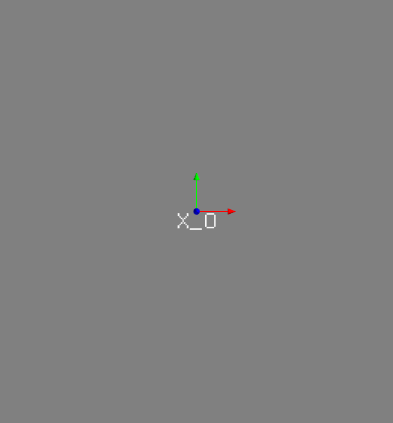

In [299]:
import numpy as np
import eigen3 as e
import spacevecalg as sva

X_O = sva.PTransformd.Identity()

# display the X_O frame with Axis
a1 = Axis(X=X_O, text='X_O', length=0.2)
a1.addActors(viewer.scene)

display()

Now let's add the foot frame represented by the transformation $ {}^{foot} X_O = plx(rz(\pi) rx(-\frac{\pi}{2}), [0.5, -0.3, 0]^T) $ and the frame CoM (Center of Mass) represented by the transformation $ {}^{CoM} X_O = xlt([-0.2, 0.8, 0]) $

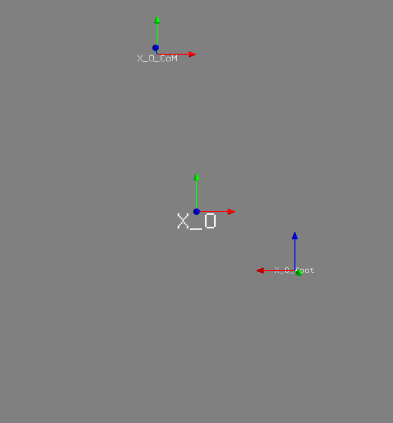

In [300]:
X_O_foot = sva.PTransformd(sva.RotZ(np.pi)*sva.RotX(-np.pi/2.), e.Vector3d(0.5, -0.3, 0.))
X_O_CoM = sva.PTransformd(e.Vector3d(-0.2, 0.8, 0.))

aFoot = Axis(X=X_O_foot, text='X_O_foot', length=0.2)
aCoM = Axis(X=X_O_CoM, text='X_O_CoM', length=0.2)

aFoot.addActors(viewer.scene)
aCoM.addActors(viewer.scene)

display()

We can easily find the transformation between the foot and the CoM by doing the following computation $ {}^{CoM} X_{foot} = {}^{CoM} X_O {}^O X_{foot} = {}^{CoM} X_O {}^{foot} X_O^{-1} $

Then we can recompute $ {}^{CoM} X_O = {}^{CoM} X_{foot} {}^{foot} X_O $

Error must be near 0: 7.85046229342e-17


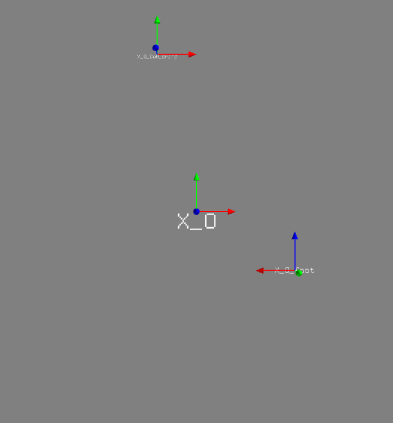

In [301]:
X_foot_CoM = X_O_CoM*X_O_foot.inv()
X_O_CoM_prime = X_foot_CoM*X_O_foot

print 'Error must be near 0:', (X_O_CoM_prime.matrix() - X_O_CoM.matrix()).norm()

# recreate the Axis marker from X_O_CoM_prime
aCoM.removeActors(viewer.scene)
aCoMP = Axis(X=X_O_CoM, text='X_O_CoM_prime', length=0.2)
aCoMP.addActors(viewer.scene)

display()

Now, we know how to transform frame. In the next section we will see how to manipulate Motion vector that can represent error, velocity, acceleration, jerk and all velocity time derivative.

## Motion vector: MotionVecd

We commonly use Motion vector ($\hat{m}$) to represent a velocity $\hat{v}$ and an acceleration $\hat{a}$.
All those vector must of course be attached to a frame.

Let's display one linear velocity vector $ \hat{v}_l $ and a pure angular velocity vector $ \hat{v}_a $ both attached to the $ X_O $ frame.

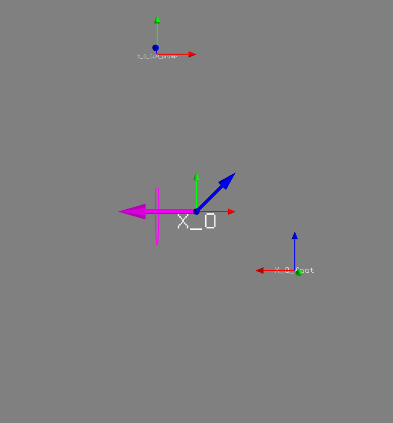

In [302]:
from graph import MotionVecViz

V_l = sva.MotionVecd(e.Vector3d.Zero(), e.Vector3d(0.2, 0.2, 0.))
V_a = sva.MotionVecd(e.Vector3d(-0.4, 0., 0.), e.Vector3d.Zero())

vizV_l = MotionVecViz(V_l, X_O) # first argument is the MotionVecd, second one is the associated PTransformd
vizV_a = MotionVecViz(V_a, X_O)

vizV_l.addActors(viewer.scene)
vizV_a.addActors(viewer.scene)
display()

The linear velocity is represented by a blue vector while the rotational velocity is represented by a magenta vector with a circle around.

Motion vector are additive so we can make the following operation $ \hat{v}_O = \hat{v}_l + \hat{v}_a $.

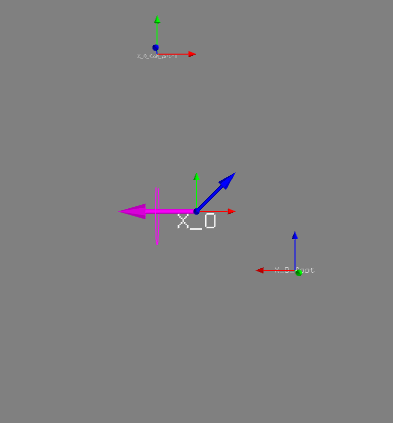

In [303]:
V_O = V_l + V_a

vizV_O = MotionVecViz(V_O, X_O)

vizV_l.removeActors(viewer.scene)
vizV_a.removeActors(viewer.scene)
vizV_O.addActors(viewer.scene)
display()

Now let's assume that the $ X_O $ frame is rigidly attached to the $ {}^{CoM} X_O $ frame.
We can compute the velocity induce by $ \hat{v}_O $ to the CoM $ \hat{v}_{CoM} $ by the following computation
$ \hat{v}_{CoM} = {}^{CoM} X_O \hat{v}_O $.

We can also do the reverse with the following computation $ \hat{v}_O = {}^O X_{CoM} \hat{v}_{CoM} = {}^{CoM} X_O^{-1} \hat{v}_{CoM} $

Error must be near 0: 0.0


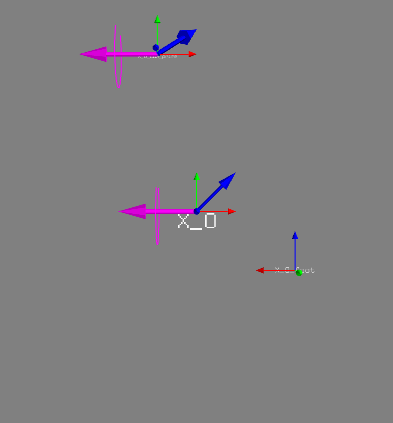

In [304]:
V_CoM = X_O_CoM*V_O
V_O_prime = X_O_CoM.invMul(V_CoM)

print 'Error must be near 0:', (V_O_prime - V_O).vector().norm()

vizV_CoM = MotionVecViz(V_CoM, X_O_CoM)

vizV_CoM.addActors(viewer.scene)
display()

You can see that the linear component of $ \hat{v}_{CoM} $ is not the same than $ \hat{v}_O $. The reason is the linear velocity is dependant of the angular velocity and the translation in $ {}^{CoM} X_O $.

It's also possible to only change the orientation of a Motion vector by applying a pure rotation on it.

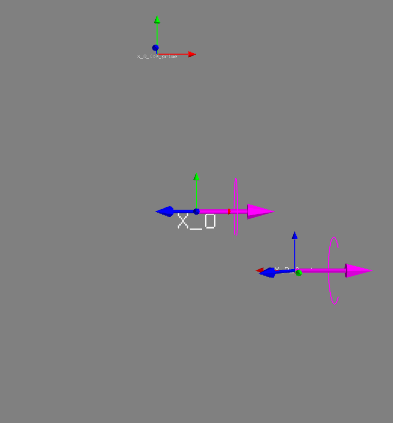

In [312]:
V_O_foot = sva.PTransformd(X_O_foot.rotation())*V_O # just keep the rotational part of the PTransformd

vizV_O.removeActors(viewer.scene)
vizV_CoM.removeActors(viewer.scene)

# vizV_O_foot is the velocity V_O at X_O in the orientation of X_O_foot
vizV_O_foot = MotionVecViz(V_O_foot, X_O)
# vizV_O is the V_O velocity in X_O_foot frame
vizV_O = MotionVecViz(V_O, X_O_foot)

vizV_O_foot.addActors(viewer.scene)
vizV_O.addActors(viewer.scene)
img = display()

vizV_O_foot.removeActors(viewer.scene)
vizV_O.removeActors(viewer.scene)
img

## Force vector: ForceVecd

We commonly use Force vector to represent a force $\hat{f}$ and a momentum $\hat{h}$.
Like Motion vector, Force vector must be attached to a frame.

This tutorial part will be really similar of the Motion vector part since Force vector and Motion vector use are really similar.
We will display a pure force vector $ \hat{f}_f $ and a pure torque vector $ \hat{f}_t $ attached to the $ {}^{foot} X_O $ frame.

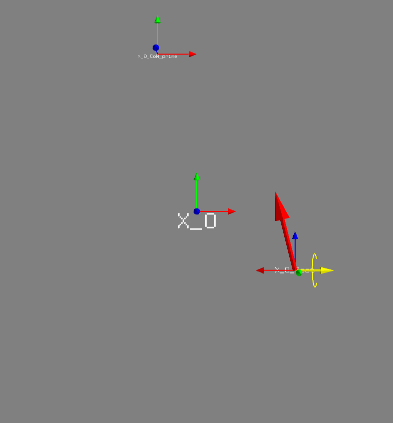

In [306]:
from graph import ForceVecViz

F_f = sva.ForceVecd(e.Vector3d.Zero(), e.Vector3d(0.1, 0., 0.4))
F_t = sva.ForceVecd(e.Vector3d(-0.2, 0., 0.), e.Vector3d.Zero())

vizF_f = ForceVecViz(F_f, X_O_foot) # first argument is the ForceVecd, second one is the associated PTransformd
vizF_t = ForceVecViz(F_t, X_O_foot)

vizF_f.addActors(viewer.scene)
vizF_t.addActors(viewer.scene)
display()

The force is represented by a red vector while the torque is represented by a yellow vector with a circle around.

Like Motion vector Force vector are additive so we can make the following operation $ \hat{f}_{foot} = \hat{f}_f + \hat{f}_t $.

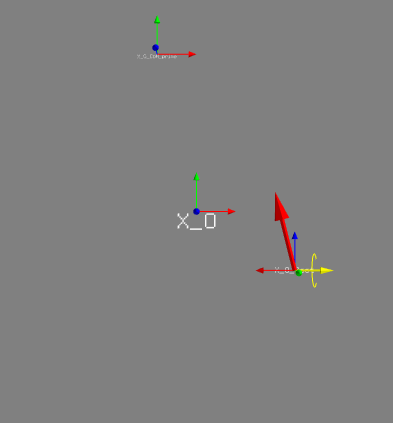

In [307]:
F_foot = F_f + F_t

vizF_foot = ForceVecViz(F_foot, X_O_foot)

vizF_f.removeActors(viewer.scene)
vizF_t.removeActors(viewer.scene)
vizF_foot.addActors(viewer.scene)
display()

By assuming the $ {}^{foot} X_O $ frame and the $ {}^{CoM} X_O $ are rigidly attached we can compute the force applied
on the $CoM$ induced by the force applied on the foot $ \hat{f}_{CoM} = {}^{CoM} X_{foot}^* \hat{f}_{foot} $.
To use a Plücker transform against a Force vector we must use the dual form $ X^* $ and to apply the inverse transformation we must use the transpose of the Plücker transform $ X^T $.

The reverse of this computation is then $ \hat{f}_{foot} = {}^{foot} X_{CoM} \hat{f}_{CoM} = {}^{foot} X_{CoM}^{T} \hat{f}_{CoM} $.

Error must be near 0: 3.85185988877e-34


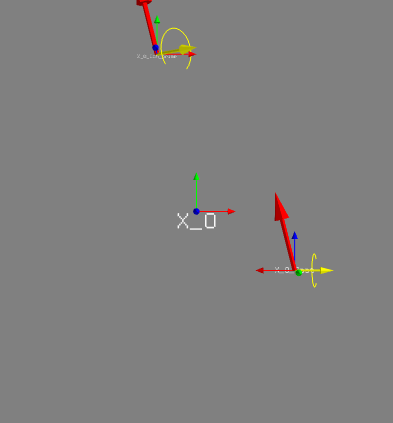

In [308]:
X_foot_CoM = X_O_CoM*X_O_foot.inv()

F_CoM = X_foot_CoM.dualMul(F_foot)
F_foot_prime = X_foot_CoM.transMul(F_CoM)

print 'Error must be near 0:', (F_foot_prime - F_foot).vector().norm()

vizF_CoM = ForceVecViz(F_CoM, X_O_CoM)

vizF_CoM.addActors(viewer.scene)
display()

The torque component of $ \hat{f}_{CoM} $ is not the same than $ \hat{f}_{foot} $. The reason is the torque is dependant of the force and the translation in $ {}^{CoM} X_{foot} $.

Like Motion vector it's possible to only change the orientation of a Force vector by applying a pure rotation on it.

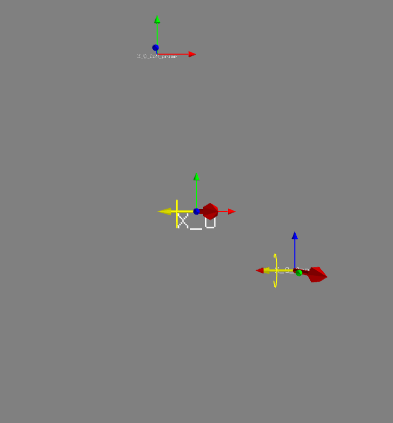

In [313]:
F_foot_O = sva.PTransformd(X_O_foot.rotation()).dualMul(F_foot) # just keep the rotational part of the PTransformd

vizF_foot.removeActors(viewer.scene)
vizF_CoM.removeActors(viewer.scene)

# vizF_O_foot is the force F_foot at X_O_foot in the orientation of X_O
vizF_O_foot = ForceVecViz(F_foot_O, X_O_foot)
# vizF_O is F_foot in X_O frame
vizF_O = ForceVecViz(F_foot, X_O)

vizF_O_foot.addActors(viewer.scene)
vizF_O.addActors(viewer.scene)
img = display()

vizF_O_foot.removeActors(viewer.scene)
vizF_O.removeActors(viewer.scene)
img

In the next section we will see that we can apply the same transformation on a Rigid Body Inertia matrix.

### Rigid Body Inertia : RBInertiad

Rigide Body Inertia $\hat{I}$ contain inertial parameter of a body :
 * mass $m$
 * center of mass $c$
 * rotational inertia matrix at the origin of a body $I$

The constructor of the RBInertiad matrix take the first moment of mass $ h = mc $ as argument.

Beware that the rotational inertia matrix $I$ must be expressed at the origin of the body.
A lot of library or file use a rotational inertia matrix expressed at the body center of mass frame $I_c$.
SpaceVecAlg provide a usefull function to make this transformation easily
```python
I = sva.inertiaToOrigin(I_c, m, c, Matrix3d.Identity())
```

Like for a Motion vector and a Force vector we can apply a Plücker transform to an Rigid Body Inertia matrix:
$$ \hat{I}^{CoM}_{foot} = {}^{CoM} X^*_{foot} \hat{I}_{foot} {}^{CoM} X^{-1}_{foot} $$
And also the inverse transformation:
$$ \hat{I}_{foot} = {}^{CoM} X^T_{foot} \hat{I}^{CoM}_{foot} {}^{CoM} X_{foot} $$

Rigid Body Inertia matrix are also additive, so we can easily merge inertia of two bodies:
$$
\hat{I}^{c}_{CoM} = \hat{I}_{CoM} + \hat{I}^{CoM}_{foot}
$$

In [310]:
m = 4.# mass
c = e.Vector3d(0.1, -0.2, 0.02) # center of mass
h = m*c # first moment of mass
I_foot_c = e.Matrix3d.Identity() # rotational inertia at center of mass
I_foot = sva.inertiaToOrigin(I_foot_c, m, c, e.Matrix3d.Identity()) # rotational inertia at body base

# create the Rigid Body Inertia of the foot body
RBI_foot = sva.RBInertiad(m, c, I_foot)

# transform foot inertia in the CoM frame and do the reverse
RBI_foot_CoM = X_foot_CoM.dualMul(RBI_foot)
RBI_foot_prime = X_foot_CoM.transMul(RBI_foot_CoM)

print 'Error must be near 0:', (RBI_foot - RBI_foot_prime).matrix().norm()
print

RBI_CoM = sva.RBInertiad(10., e.Vector3d.Zero(), e.Matrix3d.Identity())

RBI_CoM_c = RBI_CoM + RBI_foot
print 'mass:', RBI_CoM_c.mass()
print 'center of mass:', (RBI_CoM_c.momentum()/RBI_CoM_c.mass()).transpose()
print 'inertia:'
print RBI_CoM_c.inertia()

Error must be near 0: 1.15417398787e-15

mass: 14.0
center of mass: 0.00714286 -0.0142857 0.00142857
inertia:
2.1616   0.08 -0.008
  0.08 2.0416  0.016
-0.008  0.016    2.2


## Transformation error

To compute an error between two frame we can use the `sva::transformError(X_a_b, X_a_c)` function that take two `sva::PTransformd` and return a `sva::MotionVecd` that contain the translation error in the linear part and the angular error compute by logarithmic matrix on the angular part. The error is expressed in the $a$ frame.

The method `sva::transformVelocity(X_a_b)` transform a `sva::PTransformd` matrix into a `sva::MotionVecd` in the $a$ frame. This function is an equivalent of the $ XtoV $ method.

We can turn `Err_b_c = sva::transformVelocity(X_b_c)` into `Err_b_c_a = sva::transformError(X_a_b, X_a_c)` by applying a pure rotation $ {}^a E_b $ on the result.

In [321]:
Err_foot_CoM_O = sva.transformError(X_O_foot, X_O_CoM)
print 'error between foot and CoM frame in O frame'
print 'translation error', Err_foot_CoM_O.linear().transpose()
print 'orientation error', Err_foot_CoM_O.angular().transpose()
print

Err_foot_CoM = sva.transformVelocity(X_foot_CoM)
print 'error between foot and CoM frame in foot frame'
print 'translation error', Err_foot_CoM.linear().transpose()
print 'orientation error', Err_foot_CoM.angular().transpose()
print

Err_foot_CoM_O_prime = sva.PTransformd(X_O_foot.rotation()).invMul(Err_foot_CoM)
print 'We can compute the Err_foot_CoM_O error from Err_foot_CoM by applying a pure rotation from foot to O'
print 'translation error', Err_foot_CoM_O_prime.linear().transpose()
print 'orientation error', Err_foot_CoM_O_prime.angular().transpose()

error between foot and CoM frame in O frame
translation error       -0.7        1.1 1.2326e-32
orientation error 1.92367e-16 -1.5708 -1.5708

error between foot and CoM frame in foot frame
translation error         0.7 1.83697e-17         1.1
orientation error       0 -1.5708 -1.5708

We can compute the Err_foot_CoM_O error from Err_foot_CoM by applying a pure rotation from foot to O
translation error       -0.7        1.1 1.2326e-32
orientation error 1.92367e-16 -1.5708 -1.5708
